# Python wrapper test

To access the code just do:

```python
import em2d
````

Given that we are still in development mode, I am triggering a reload of the module every time the notebook is evaluated using `importlib`. This will not be required during stable operation.

## Module information

The module has been extensively documented. Documentation can be accessed through the `help()` and `%pdoc` commands.

Information regarding the system, namely OpenMP threads and SIMD support can be printed using the `em2d.zpic.sys_info()` command.

In [54]:
import em2d
import importlib
importlib.reload( em2d )

sim = em2d.Simulation( [8,8], [16,16], [12.8,12.8], 0.07 )
help(sim)

# %pdoc em2d.laser.PlaneWave

# You can get OpenMP / SIMD information using zpic.sys_info()
em2d.zpic.sys_info()

Help on Simulation object:

class Simulation(builtins.object)
 |  Simulation( ntiles, nx, box, dt, species = None )
 |
 |  Class representing an em2d simulation
 |
 |  Parameters
 |  ----------
 |  ntiles : { int, int }
 |      Number of tiles (x,y) in the simulation grid
 |  nx : { int, int }
 |      Size (x,y) of individual tiles
 |  box : { float, float }
 |      Simulation box size (x,y) in simulation units
 |  dt : float
 |      Simulation time step in simulation units
 |  species : Species or list of Species
 |      Species or list of Species to be added to the simulation. Defaults to None,
 |      meaning no species will be used.
 |  moving_window : boolean
 |      Use a moving window for the simulation, defaults to False
 |
 |  Methods defined here:
 |
 |  __reduce__ = __reduce_cython__(...)
 |
 |  __setstate__ = __setstate_cython__(...)
 |
 |  add(self, src)
 |      add( src )
 |
 |      Add object to simulation
 |
 |      Parameters
 |      ----------
 |      src : object
 | 

## Weibel simulation



### Prepare and run simulation

The `dims` variable corresponds to the global grid size. The cell size is set to $0.1^2$

In [50]:
import em2d
import importlib
importlib.reload( em2d )

# Grid parameters
dims   = [ 128, 128 ]
ntiles = [ 8, 8 ]
box = [ 0.1 * dims[0], 0.1 * dims[1] ]

# Simulation time
tmax   = 35.0

# Particle species
electrons = em2d.Species( "electrons", -1, [4,4], 
                           udist = em2d.udist.ThermalCorr( [0.1, 0.1, 0.1], [ 0, 0, +0.6 ] ) )

positrons = em2d.Species( "positrons", +1, [4,4], 
                           udist = em2d.udist.ThermalCorr( [0.1, 0.1, 0.1], [ 0, 0, -0.6 ] ) )


# Create simulation object
nx = [ dims[0]/ntiles[0], dims[1]/ntiles[1] ]
dt = 0.07
sim = em2d.Simulation( ntiles, nx, box, dt, species = [electrons, positrons] )

# Iterate up to tmax
while sim.t < tmax:
    sim.advance()

print( "Simulation run up to t = {}".format(sim.t))

Simulation run up to t = 35.0


### Plot data directly from memory

Simulation objects have `plot`/`vplot` methods that may be called for generating a plot similar to what you would obtain by saving the file and opening it through `visxd`.

(*info*) Energy at n = 500, t = 35
(*info*) electrons = 14.2925
(*info*) positrons = 14.3845
(*info*) Total particle energy = 28.6771
(*info*) Electric field = 4024.27
(*info*) Magnetic field = 1895.62
(*info*) total = 5948.57


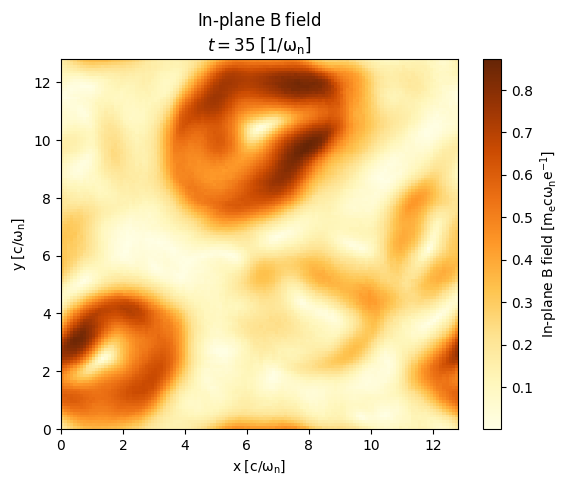

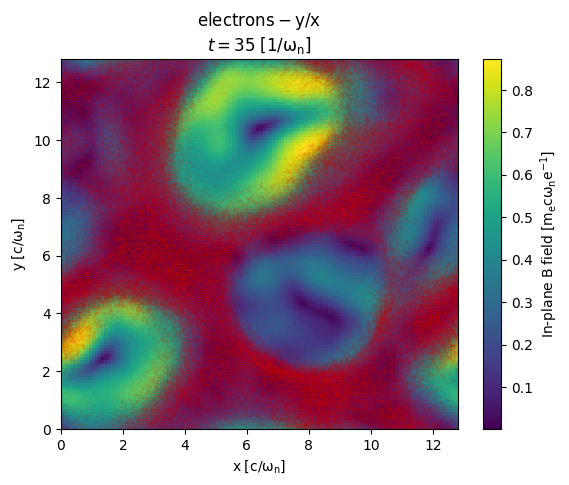

In [51]:
# Print energy information
sim.energy_info()

# sim.emf.plot('E','x', vsim = True, cmap = "RdYlBu")
sim.emf.vplot('B', cmap = "YlOrBr")

# sim.current.vplot()

# Overlap particle data
sim.emf.vplot('B', show = False)
electrons.plot( 'x', 'y', c = 'r', grid = False )

### Access simulation data

Data is returned as NumPy arrays. Note that the data is copied from simulation memory each time the `gather()` functions are called.

In [ ]:
Bx = sim.emf.B.gather('x')

Jz = sim.current.J.gather('z')

e_ux = electrons.gather('ux')
e_ux

### Save data to disk

Simulation data can be saved to disk for further analysis.

In [ ]:
sim.emf.save('B','x')
sim.emf.save('B','y')
sim.emf.save('B','z')

sim.current.save( 'z' )

# Save particle data
electrons.save()

## LWFA simulation

In [1]:
import em2d
import importlib
importlib.reload( em2d )

# Grid parameters
dims   = [ 1024, 256 ]
nx     = [ 32, 32 ]
box = [ 20.48, 25.6 ]

# Simulation time
dt = em2d.zpic.courant( dims = dims, box = box ) * 0.9
tmax   = 22.0

# Particle species
electrons = em2d.Species( "electrons", -1, [2,2], 
                           density = em2d.density.Step( 'x', 1.0, 20.48 ) )

# Create simulation object
ntiles = [ dims[0]/nx[0], dims[1]/nx[1] ]
sim = em2d.Simulation( ntiles, nx, box, dt, species = electrons, moving_window = True )

# Set current filtering
sim.current.set_filter( em2d.filter.Compensated( 'x', 4 ) )

# Add laser
sim.add( em2d.laser.Gaussian( 
    start = 17.0, fwhm = 2.0, a0 = 2.0, omega0 = 10.0, 
    W0 = 4.0, focus = 20.0, axis = 12.8, sin_pol = 1 ) )

# Iterate up to tmax
while sim.t < tmax:
    sim.advance()

print( "Simulation run up to t = {}".format(sim.t))

Simulation run up to t = 22.010114195756614


### Plot simulation results

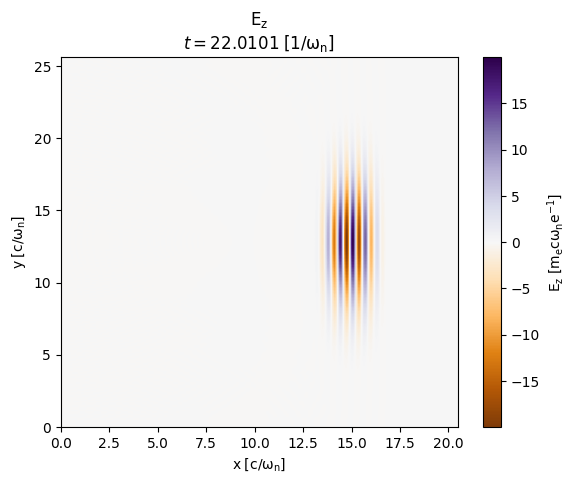

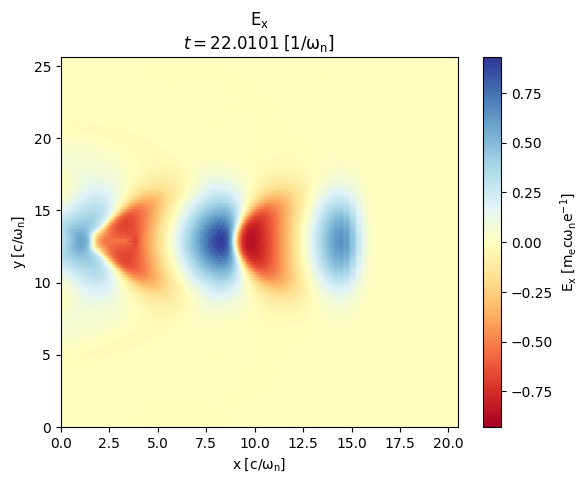

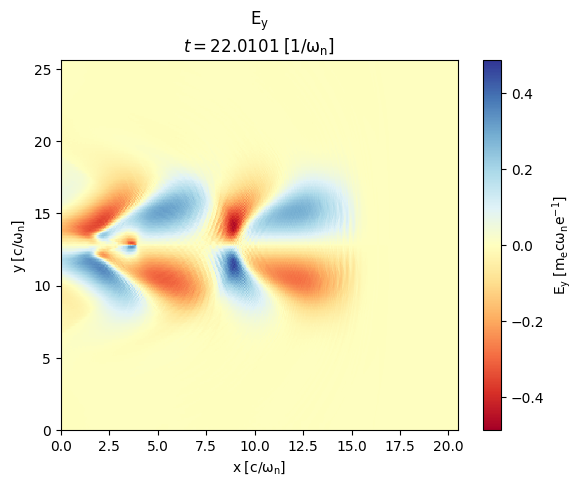

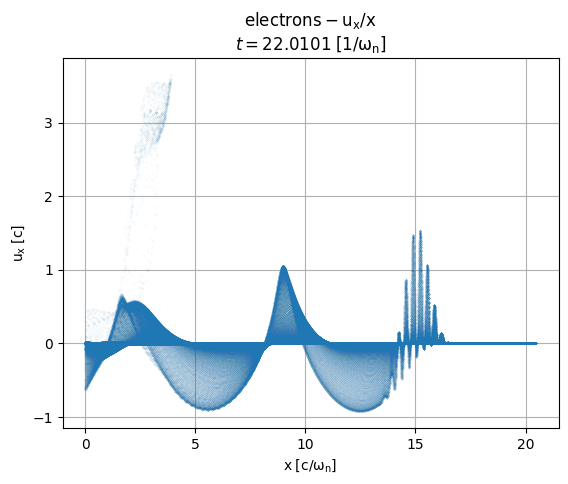

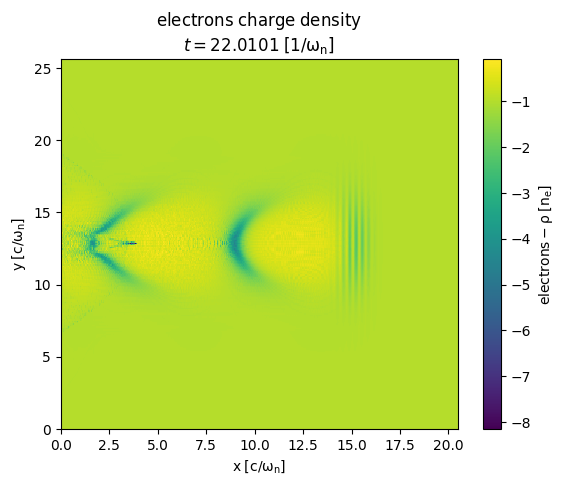

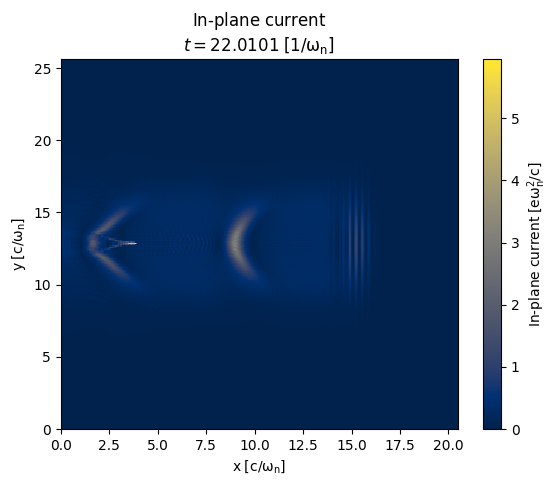

In [56]:
import visxd
import importlib
importlib.reload( visxd )

sim.emf.plot('E','z', vsim = True, cmap = "PuOr")
sim.emf.plot('E','x', vsim = True, cmap = "RdYlBu")
sim.emf.plot('E','y', vsim = True, cmap = "RdYlBu")

electrons.plot( 'x', 'ux', ms = 0.05 )
electrons.plot_charge()

sim.current.vplot( cmap = "cividis")

### Overplot example

Using the `show` parameter we can delay displaying a plot, allowing for other quantity to be added to the same plot

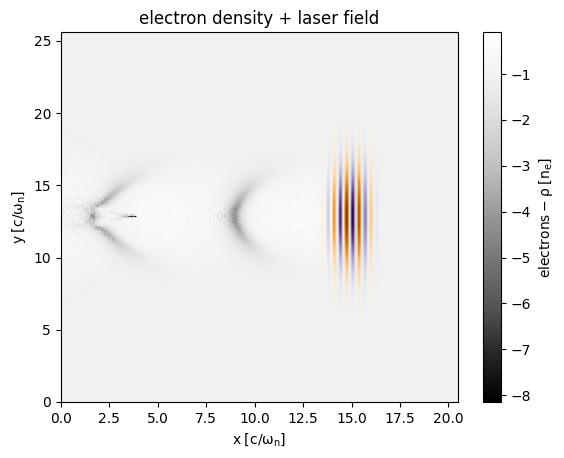

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Plot charge density but don't show it yet
electrons.plot_charge( cmap = "Greys_r", show = False )

# Gather laser data
laser = sim.emf.E.gather( 'z' )

# Find absolute maximum
amax = np.amax( np.abs(laser) )

# Set alpha values (range 0 to 1). Other scales are possible
alpha = np.sqrt( np.abs(laser) / amax )

# Overplot laser field
plt.imshow( laser, alpha = alpha, cmap = 'PuOr', vmin = -amax, vmax = amax,
            extent = ( 0, box[0], 0, box[1] ), 
            interpolation = 'nearest', origin = 'lower',
            aspect = 'auto' )

# (optional) add additional color axis 
# plt.colorbar().set_label( 'laser' )

# Set new title
plt.title( 'electron density + laser field')

# Display plot
plt.show()

### Phasespace density

Simulation species can also generate phasespace density grids (and plot them) on demand:

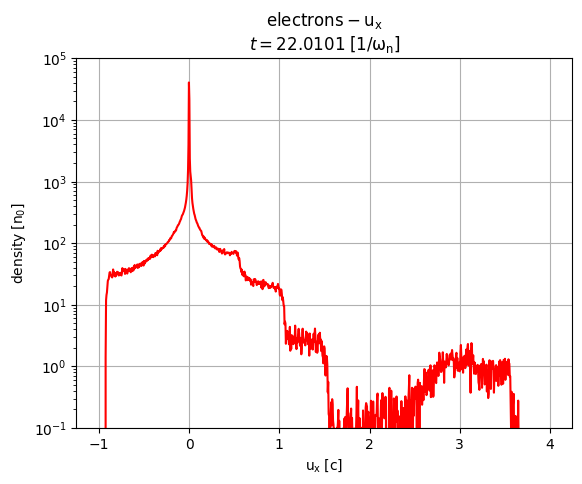

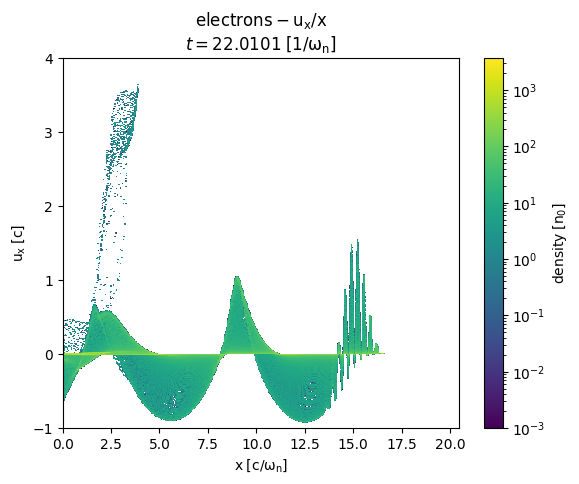

In [27]:
import visxd
import importlib
importlib.reload( visxd )

electrons.plot_phasespace( 
    'ux', [ -1., 4. ], 1024, yscale = "log", c = 'r', ylim = ( 0.1, 1e5 ) )

electrons.plot_phasespace( 
    'x', [ 0, 20.48 ], 512,
    'ux', [ -1., 4. ], 1024, norm = "log", vmin = 1.e-3 )
